# 🤖 Multi-Agent Systems Workshop 🧠

> **Date**: May 21, 2025

Welcome to our hands-on workshop on building multi-agent systems! In this notebook, you'll learn how to create intelligent agent systems that can collaborate to solve complex tasks. We'll build a travel assistant that helps with restaurant recommendations, weather forecasts, and event discovery.

## 🗺️ Workshop Roadmap

```mermaid
flowchart TD
    A[Setup & Imports] --> B[Build Restaurant Agent]
    A --> C[Build Weather Agent]
    A --> D[Build Events Agent]
    B --> E[Create Multi-Agent Architecture]
    C --> E
    D --> E
    E --> F[Test Your System!]
    
    style A fill:#f9d77e,stroke:#f9bc02,color:black
    style B fill:#a8e6cf,stroke:#1b998b,color:black
    style C fill:#ffd3b6,stroke:#ff8b94,color:black
    style D fill:#d5b3ff,stroke:#9775fa,color:black
    style E fill:#77d5fa,stroke:#0984e3,color:black
    style F fill:#badc58,stroke:#6ab04c,color:black
```

> 💡 **Pro Tip**: Each agent in our system is like a specialist with its own superpowers. When they work together, they form an AI dream team!

Let's dive in and create some AI magic! 🪄

## All imports

In [ ]:
## 📦 Setting Up Our Toolkit

# Core libraries for functionality
import logging  # For logging messages and debugging
import sqlite3  # For database operations with our reservations system
from datetime import datetime, date  # For handling dates and times
import requests  # For making HTTP requests to external APIs
import os  # For interacting with the operating system
import pandas as pd  # For data manipulation and analysis
import xml.etree.ElementTree as ET  # For XML parsing
import dotenv  # For loading environment variables
from typing import *  # For type hints

# LangChain and LLM specific imports
from langchain_core.runnables import RunnableConfig  # For LangChain configurations
from langchain_core.tools import tool  # For creating tools our agents can use
from langchain_openai import OpenAIEmbeddings  # For text embeddings
from langchain_chroma import Chroma  # For vector database operations

# External service imports
from opencage.geocoder import OpenCageGeocode  # For geocoding services

# LangGraph specific imports (our multi-agent framework)
from langgraph.prebuilt import create_react_agent  # For creating ReAct agents

## 🔑 API Keys - Our Magical Access Tokens

Below, we're loading API keys from a `.env` file. These are the special passcodes that let our agents talk to services like OpenAI, Tavily search, and OpenWeatherMap.

> 🔐 **Note**: Make sure you have a `.env` file in your `./data/` directory with the necessary API keys! Our agents can't perform their magic without these.

In [60]:
env_values = dotenv.dotenv_values("./data/.env")
os.environ["OPENAI_API_KEY"] = env_values.get("OPENAI_API_KEY")
os.environ["TAVILY_API_KEY"] = env_values.get("TAVILY_API_KEY")
os.environ["OPENWEATHERMAP_API_KEY"] = env_values.get("OPENWEATHERMAP_API_KEY")

## 🔧 Helper Functions - The Backstage Crew

These utility functions help us display agent messages neatly. Think of them as the backstage crew making sure everything looks good for the audience (that's you!).

In [46]:
# hide-cell
from langchain_core.messages import convert_to_messages


def pretty_print_message(message, indent=False):
    pretty_message = message.pretty_repr(html=True)
    if not indent:
        print(pretty_message)
        return

    indented = "\n".join("\t" + c for c in pretty_message.split("\n"))
    print(indented)


def pretty_print_messages(update, last_message=False):
    is_subgraph = False
    if isinstance(update, tuple):
        ns, update = update
        # skip parent graph updates in the printouts
        if len(ns) == 0:
            return

        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:")
        print("\n")
        is_subgraph = True

    for node_name, node_update in update.items():
        update_label = f"Update from node {node_name}:"
        if is_subgraph:
            update_label = "\t" + update_label

        print(update_label)
        print("\n")

        messages = convert_to_messages(node_update["messages"])
        if last_message:
            messages = messages[-1:]

        for m in messages:
            pretty_print_message(m, indent=is_subgraph)
        print("\n")

# 🍜 Restaurant Recommendation Agent 🍽️

Our first agent specializes in finding the perfect restaurant for hungry travelers. Whether you're craving pasta in Rome or sushi in Tokyo, this agent has your cravings covered!

```mermaid
flowchart LR
    A[User Query] --> B[Restaurant Agent]
    B --> C{Database Check}
    C -->|Found| D[Recommend from DB]
    C -->|Not Found| E[Search Online]
    D --> F[Format Results]
    E --> F
    F --> G[Restaurant Recommendations]
    
    style B fill:#a8e6cf,stroke:#1b998b,color:black
    style C fill:#ffd3b6,stroke:#ff8b94,color:black
    style G fill:#badc58,stroke:#6ab04c,color:black
```

> 💡 **Fun Fact**: This agent can search both our curated database of restaurants AND the wider web. It's like having a food critic and internet researcher rolled into one hungry AI!

## 🔨 Restaurant Agent Tools - The Chef's Kit

These tools give our restaurant agent its superpowers! From searching databases to booking tables, these functions are the secret ingredients to our agent's success.

> 🧰 **Tool Overview**:
> - `fetch_restaurant_from_database`: Searches our local restaurant database
> - `fetch_restaurant_from_search`: Searches online for restaurant information
> - `add_reservation`: Books a table at a restaurant
> - `get_all_reservations`: Retrieves all booked reservations
> - `cancel_reservation`: Cancels an existing reservation

In [ ]:
# Tool 1: Database search for restaurants with filtering capabilities
@tool
def fetch_restaurant_from_database(city, cuisine=None, price=None, top_n=10):
    """
    Search for restaurants by city and optionally by cuisine and price range.
    
    Args:
        city (str): The city to search restaurants in
        cuisine (str, optional): Type of cuisine (e.g., 'French', 'Dutch')
        price (str, optional): Price range (e.g., '$', '$$', '$$ - $$$', '$$$$')
        top_n (int, optional): Number of top restaurants to return, default 10
        
    Returns:
        DataFrame: Top n restaurants matching the criteria, sorted by Rating (descending)
    """
    # Load the data from our curated restaurant database
    df = pd.read_csv('./data/TA_restaurants_curated.csv')
    
    # Filter by city (case insensitive to make it user-friendly)
    results = df[df['City'].str.lower() == city.lower()]
    
    # Filter by cuisine if specified
    if cuisine:
        # Cuisine is stored as a list in string format, so we need to check if the cuisine
        # is in the list. The evaluation requires converting the string to an actual list.
        results = results[results['Cuisine Style'].apply(
            lambda x: cuisine in eval(x) if isinstance(x, str) and pd.notna(x) else False
        )]
    
    # Filter by price if specified
    if price:
        results = results[results['Price Range'] == price]
    
    # Sort by Rating (descending) and then by Number of Reviews to break ties
    results = results.sort_values(by=['Rating', 'Number of Reviews'], ascending=[False, False])
    
    # Return the top N results (or all if fewer than N)
    return results.head(top_n)[['Name', 'Cuisine Style', 'Rating', 'Price Range', 'Number of Reviews']]


# Tool 2: Web search for restaurant information using Tavily API
from tavily import TavilyClient
@tool
def fetch_restaurant_from_search(city: str, cuisine: str) -> str:
    """Searches for restaurants based on city and cuisine type using Tavily search.
    
    This function uses the Tavily search API to find information about the best
    restaurants of a specific cuisine type in the given city.
    
    Args:
        city: A string representing the city to search for restaurants in.
        cuisine: A string representing the cuisine type to search for.
        
    Returns:
        A string containing concatenated content of search results about restaurants.
        
    Raises:
        KeyError: If TAVILY_API_KEY environment variable is not set.
    """
    # Initialize the Tavily search client with our API key
    client = TavilyClient(api_key=os.environ['TAVILY_API_KEY'])
    
    # Create a natural language query to find the best restaurants
    query = f"What are the best {cuisine} restaurants in {city}?"
    
    # Perform the search with advanced depth for better results
    response = client.search(query, search_depth="advanced")
    
    # Concatenate all the search results into a single string
    results_content = "\n\n".join([result['content'] for result in response['results']])
    return results_content

# Tool 3: Add a new restaurant reservation to our database
@tool
def add_reservation(restaurant_name, reservation_time, party_size, notes=None):
    """Adds a new restaurant reservation to the database.

    Args:
        restaurant_name (str): Name of the restaurant for the reservation.
        reservation_time (str): Date and time of the reservation.
        party_size (int): Number of people in the party.
        notes (str, optional): Additional notes for the reservation.

    Returns:
        int: ID of the newly created reservation.
    """
    # Connect to the SQLite database
    conn = sqlite3.connect('./data/reservations.db')
    cursor = conn.cursor()
    
    # Record the current time as the booking time
    booking_time = datetime.now()
    
    # Insert the reservation details into the database
    cursor.execute('''
    INSERT INTO restaurant_reservations
    (restaurant_name, reservation_time, booking_time, party_size, notes)
    VALUES (?, ?, ?, ?, ?)
    ''', (restaurant_name, reservation_time, booking_time, party_size, notes))
    
    # Commit the changes and close the connection
    conn.commit()
    cursor.close()
    conn.close()
    
    # Return the ID of the new reservation
    return cursor.lastrowid

# Tool 4: Retrieve all restaurant reservations from the database
@tool
def get_all_reservations():
    """Retrieves all restaurant reservations from the database.

    Returns:
        list: List of dictionaries containing reservation details,
              ordered by reservation time.
    """
    # Connect to the SQLite database
    conn = sqlite3.connect('./data/reservations.db')
    cursor = conn.cursor()
    
    # Fetch all reservations ordered by reservation time
    cursor.execute('SELECT * FROM restaurant_reservations ORDER BY reservation_time')
    
    # Get column names from the cursor description
    columns = [description[0] for description in cursor.description]
    
    # Create a list of dictionaries, each representing a reservation
    reservations = [dict(zip(columns, row)) for row in cursor.fetchall()]
    
    # Close the connection and return the reservations
    cursor.close()
    conn.close()
    return reservations

# Tool 5: Cancel an existing restaurant reservation
@tool
def cancel_reservation(reservation_id):
    """Cancels a restaurant reservation by its ID.

    Args:
        reservation_id (int): ID of the reservation to cancel.

    Returns:
        bool: True if the reservation was successfully canceled, False otherwise.
    """
    # Connect to the SQLite database
    conn = sqlite3.connect('./data/reservations.db')
    cursor = conn.cursor()
    
    # Delete the reservation with the specified ID
    cursor.execute('DELETE FROM restaurant_reservations WHERE id = ?', (reservation_id,))
    
    # Commit the changes and close the connection
    conn.commit()
    cursor.close()
    conn.close()
    
    # Return True if at least one row was affected (reservation was found and deleted)
    return cursor.rowcount > 0

## 🥘 Creating Our Restaurant Agent - The Foodie AI

Now we'll create our restaurant recommendation agent using LangGraph's `create_react_agent` function. This creates an agent that follows the ReAct (Reasoning + Acting) paradigm - it thinks about what to do, then takes actions based on that reasoning.

> 💡 **What's happening here?** We're creating an agent with:
> 1. A powerful language model (GPT-4.1)
> 2. Access to our restaurant tools
> 3. Instructions on how to help users find restaurants and manage reservations

In [ ]:
# Create our restaurant recommendation agent using LangGraph's ReAct framework
restaurant_search_agent = create_react_agent(
    # We're using OpenAI's GPT-4.1 for powerful natural language understanding
    model="openai:gpt-4.1",
    
    # These are the tools our agent can use to accomplish tasks
    tools=[
        fetch_restaurant_from_database,  # Search our local restaurant database
        fetch_restaurant_from_search,    # Search the web for restaurant info
        add_reservation,                 # Add a new restaurant reservation
        get_all_reservations,            # Retrieve existing reservations
        cancel_reservation               # Cancel a reservation
        ],
    
    # This prompt tells the agent what its job is and how to behave
    prompt=(
        "You are a helpful restaurant recommendation assistant. "
        "INSTRUCTIONS:"
        "When a user asks for restaurant recommendations, first use fetch_restaurant_from_database to check if we have restaurant data for the requested city and cuisine."
        "If no matching results are found in the database, then use fetch_restaurant_from_search to find recommendations online."
        "Always provide recommendations based on the city and cuisine type specified by the user."
        "If the user doesn't specify both city and cuisine, ask them to provide this information."
        "Present your recommendations in an organized manner with relevant details about each restaurant when available."
        "\n\nFormat messages in markdown (use lists, use tables for better readability)."
        f"\nCurrent time: {datetime.now()}."
    ),
    
    # A name for our agent - useful for debugging and when we have multiple agents
    name="restaurant_search_agent",
)

## 🤔 Let's Test Our Restaurant Agent!

Now that we've built our agent, let's see it in action! We'll ask it to find French restaurants in Paris - a classic culinary adventure.

> 🍾 **Note**: When you run this cell, you'll see the agent's thought process and its interactions with tools in real-time. It's like watching a chef work in the kitchen!

In [ ]:
for chunk in restaurant_search_agent.stream(
    {"messages": [{"role": "user", "content": "I am traveling to Paris and I want to eat French food. Can you help me find a restaurant?"}]},
):
    pretty_print_messages(chunk)

Update from node agent:


================================== Ai Message ==================================
Name: restaurant_search_agent
Tool Calls:
  fetch_restaurant_from_database (call_wOCcyjdUEPnZXTlXjrdXDyoM)
 Call ID: call_wOCcyjdUEPnZXTlXjrdXDyoM
  Args:
    city: Paris
    cuisine: French
    top_n: 5


Update from node tools:


================================= Tool Message =================================
Name: fetch_restaurant_from_database

                     Name                                      Cuisine Style  \
89401             Epicure  ['French', 'European', 'Vegetarian Friendly', ...   
89404  Il Etait Un Square    ['French', 'Steakhouse', 'Vegetarian Friendly']   
89405             Boutary  ['French', 'Seafood', 'Gastropub', 'European',...   
89399               ASPIC             ['French', 'European', 'Contemporary']   
89413            Alliance  ['French', 'Vegetarian Friendly', 'Vegan Optio...   

       Rating Price Range  Number of Reviews  
89401     5.0 

# ☀️ Weather Agent 🌧️

Our second specialist agent will help users check the weather conditions in different cities. Perfect for planning that picnic or knowing whether to pack an umbrella!

```mermaid
flowchart LR
    A[User Query] --> B[Weather Agent]
    B --> C[Extract Location]
    C --> D[Call Weather API] 
    D --> E[Format Response]
    E --> F[Weather Forecast]
    
    style B fill:#ffd3b6,stroke:#ff8b94,color:black
    style F fill:#badc58,stroke:#6ab04c,color:black
```

> 💡 **Fun Fact**: Weather APIs can give us real-time data for almost anywhere on the planet! Our agent is like a meteorologist that never sleeps (and hopefully never gets the forecast wrong).

## 🔨 Weather Agent Tools - The Weather Station

Our weather agent needs a way to check current weather conditions. For this, we'll create a tool that connects to the OpenWeatherMap API - a popular service for weather data.

> 🌧️ **How it works**: The agent will take a city name from the user, pass it to this tool, and the tool will fetch the latest weather data from OpenWeatherMap.

In [ ]:
# Import the OpenWeatherMap wrapper from LangChain
from langchain_community.utilities import OpenWeatherMapAPIWrapper

# Create our weather tool that will fetch current weather data
@tool
def weather_tool(city: str) -> str:
        """Gets the current weather information for a specified city.
        
        This tool uses the OpenWeatherMap API to retrieve current weather conditions
        including temperature, humidity, wind speed, and general conditions for the
        specified location.
        
        Args:
                city: A string representing the city name to retrieve weather information for.
                        
        Returns:
                A string containing formatted weather information for the requested city.
                
        Raises:
                ValueError: If the city name is invalid or not found.
                RuntimeError: If there's an API connection issue or authentication problem.
        """
        # Initialize the OpenWeatherMap wrapper with our API key
        weather = OpenWeatherMapAPIWrapper()
        
        # Call the API with the city name (stripped of whitespace)
        tool_result = weather.run(city.strip())
        
        # Return the formatted weather information
        return tool_result

### Agent

## 🌤️ Creating Our Weather Agent - The Forecast Friend

Now we'll create our weather agent using the same ReAct framework as our restaurant agent. This agent will specialize in answering questions about current weather conditions in cities around the world.

> 💡 **Agent Design**: This agent is simpler than our restaurant agent because it only needs one tool. But sometimes specialization is better than complexity!

In [ ]:
# Create our weather information agent
weather_agent = create_react_agent(
    # Using the powerful GPT-4.1 model for natural language understanding
    model="openai:gpt-4.1",
    
    # This agent only needs our one weather tool
    tools=[
        weather_tool
        ],
    
    # This prompt tells the agent its job is to help with weather information
    prompt=(
        "You are a helpful weather assistant. "
        "INSTRUCTIONS:"
        "Use the provided tools to check current weather conditions for cities requested by users."
        "Provide concise summaries of temperature, conditions, and other relevant weather information."
        "If the city information is missing or unclear, ask the user to specify which city they're interested in."
        f"\nCurrent time: {datetime.now()}."
    ),
    
    # A name for our agent
    name="weather_agent",
)

## 🌦️ Testing Our Weather Wizard

Time to see if our Weather Agent can handle the forecast! Let's ask about the weather in Paris.

> 🌞 **Note**: The agent will call the OpenWeatherMap API with our query. Will it be sunny in Paris? Or should you pack that fashionable raincoat? Let's find out!

In [63]:
for chunk in weather_agent.stream(
    {"messages": [{"role": "user", "content": "What is the weather Paris?"}]},
):
    pretty_print_messages(chunk)

Update from node agent:


================================== Ai Message ==================================
Name: weather_agent
Tool Calls:
  weather_tool (call_GFzE51Y2bjO7qIyoonGc79WZ)
 Call ID: call_GFzE51Y2bjO7qIyoonGc79WZ
  Args:
    city: Paris


Update from node tools:


================================= Tool Message =================================
Name: weather_tool

In Paris, the current weather is as follows:
Detailed status: light rain
Wind speed: 4.12 m/s, direction: 40°
Humidity: 69%
Temperature: 
  - Current: 14.76°C
  - High: 15.76°C
  - Low: 13.88°C
  - Feels like: 14.09°C
Rain: {'1h': 0.37}
Heat index: None
Cloud cover: 75%


Update from node agent:


================================== Ai Message ==================================
Name: weather_agent

The current weather in Paris is light rain with a temperature of 14.8°C (feels like 14.1°C). Humidity is at 69%, and there's a gentle wind blowing at 4.1 m/s from the northeast. Cloud cover is 75%, and there's been about

# 🎉 Events Finder Agent 🎭

Our third agent is an event discovery specialist that helps users find exciting activities in their destination city. Whether you're looking for concerts, sports events, art exhibitions, or salsa dancing, this agent will help you find the fun!

```mermaid
flowchart LR
    A[User Query] --> B[Events Agent]
    B --> C[Extract Location & Event Type]
    C --> D[Search Online]
    D --> E[Format Results]
    E --> F[Event Recommendations]
    
    style B fill:#d5b3ff,stroke:#9775fa,color:black
    style F fill:#badc58,stroke:#6ab04c,color:black
```

> 💡 **Fun Fact**: This agent might discover events that even locals don't know about! It's like having a well-connected friend in every city you visit.

## 🔨 Events Finder Tool - The Local Guide

Our events finder agent needs a way to discover what's happening in different cities. For this, we'll create a tool that searches the web for upcoming events.

> 📅 **How it works**: The agent will take a city name and optional event type from the user, then use the Tavily search API to find relevant events happening in that location. It's like having a digital concierge with insider knowledge!

In [ ]:
# Import Tavily client for web searching capabilities
from tavily import TavilyClient

# Create our events finder tool
@tool
def search_events_tool(city: str, event_type: str = None) -> str:
        """Search for upcoming events in a specified city.
        
        Utilizes the Tavily search API to find information about events in the given city.
        
        Args:
                city: A string representing the city name to search for events in.
                event_type: An optional string specifying the type of events to search for (e.g., 'concerts', 'sports').
                
        Returns:
                A string containing concatenated content of search results about upcoming events.
                
        Raises:
                KeyError: If TAVILY_API_KEY environment variable is not set.
        """
        # Initialize the Tavily search client with our API key
        client = TavilyClient(api_key=os.environ['TAVILY_API_KEY'])
        
        # Build our search query based on city and optional event type
        query = f"What are the upcoming {event_type + ' ' if event_type else ''}events in {city}?"
        
        # Perform the search with advanced depth for more comprehensive results
        response = client.search(query, search_depth="advanced")
        
        # Concatenate all the search results into a single string
        results_content = "\n\n".join([result['content'] for result in response['results']])
        return results_content

### agent

## 🌆 Creating Our Events Finder Agent - The Entertainment Expert

Now we'll create our events finder agent using the ReAct framework. This agent will help users discover exciting activities and events in their destination city.

> 💡 **Agent Design**: Like our weather agent, this one uses a single specialized tool, but it's configured to understand various types of events and activities users might be interested in.

In [ ]:
# Create our events discovery agent
event_finding_agent = create_react_agent(
    # Using the powerful GPT-4.1 model for natural language understanding
    model="openai:gpt-4.1",
    
    # This agent only needs our events search tool
    tools=[
        search_events_tool
        ],
    
    # This prompt tells the agent its job is to help find exciting events
    prompt=(
        "You are a helpful event discovery assistant. "
        "INSTRUCTIONS:"
        "Use the provided tools to search for and provide information about upcoming events in various cities."
        "When a user asks about events in a specific city, provide a well-organized summary of upcoming events."
        "Include details such as event names, dates, venues, and brief descriptions when available."
        "If the city information is missing or unclear, ask the user to specify which city they're interested in."
        "\n\nFormat messages in markdown (use lists, use tables for better readability)."
        f"\nCurrent time: {datetime.now()}."
    ),
    
    # A name for our agent
    name="event_finding_agent",
)

## 🕺 Testing Our Events Guru

Time to put our Events Finder Agent to work! Let's see if it can find salsa events in Paris for our dancing enthusiasts.

> 💃 **Note**: When you run this cell, the agent will search the web for the latest salsa events in Paris. Who knows - you might want to pack your dancing shoes after seeing these results!

In [74]:
for chunk in event_finding_agent.stream(
    {"messages": [{"role": "user", "content": "Show me upcoming salsa events in Paris."}]},
):
    pretty_print_messages(chunk)

Update from node agent:


================================== Ai Message ==================================
Name: event_finding_agent
Tool Calls:
  search_events_tool (call_PYApfngrcXvhp71bXuWKMeY0)
 Call ID: call_PYApfngrcXvhp71bXuWKMeY0
  Args:
    city: Paris
    event_type: salsa


Update from node tools:


================================= Tool Message =================================
Name: search_events_tool

Host Control

Upcoming salsa events in Paris

Salsa Events in 							Paris

Salsa Events in 									Paris

Desorden Publico | Pan Piper - Paris | 25.05.2025

TROPiTECA BLOCK PARTY 🌴 #Salsa #Merengue #Cumbia #Bachata #Reggaeton ... y mááás !

Mensuelle Callesol 100% cubaine - Kouamé - DJ Didi & Tom Nka

OBINISA collectif

Siácara en concert + cours de salsa cubaine

La Habanera - White Party - Thanks for all - Fethe - DJ Mas Lefox - 14 juin 2025

Issac Delgado Release Party [...] Date | Event | Venue
25 May 2025 | Desorden Publico  Pan Piper - Paris  25.05.2025 | Pan Piper P

# 🌐 Building Our Multi-Agent System - The AI Dream Team

Now comes the exciting part! We've created three specialized agents, each with its own expertise:

1. 🍜 **Restaurant Agent**: Expert at finding places to eat
2. ☀️ **Weather Agent**: Specialist in weather forecasts
3. 🎉 **Events Agent**: Pro at discovering local activities

But having them work separately is like having experts who don't talk to each other. Let's unite them under a **Supervisor** that can route user requests to the right specialist!

```mermaid
flowchart TD
    A[User] -->|Query| B[Supervisor]
    B -->|Restaurant questions| C[Restaurant Agent]
    B -->|Weather questions| D[Weather Agent]
    B -->|Events questions| E[Events Agent]
    C -->|Response| B
    D -->|Response| B
    E -->|Response| B
    B -->|Final Answer| A
    
    style B fill:#77d5fa,stroke:#0984e3,color:black
    style C fill:#a8e6cf,stroke:#1b998b,color:black
    style D fill:#ffd3b6,stroke:#ff8b94,color:black
    style E fill:#d5b3ff,stroke:#9775fa,color:black
```

> 💡 **What's happening here?** We're creating a multi-agent system where the Supervisor acts as the coordinator. It receives user queries, determines which specialist agent should handle them, and then returns the expert's response to the user. It's like having a receptionist who directs you to the right department!

In [ ]:
# Import the necessary components for creating our supervisor
from langgraph_supervisor import create_supervisor
from langchain.chat_models import init_chat_model

# Create our supervisor that will coordinate between our three specialist agents
supervisor = create_supervisor(
    # Use GPT-4.1 for the supervisor's brain
    model=init_chat_model("openai:gpt-4.1"),
    
    # These are the specialist agents our supervisor can delegate tasks to
    agents=[restaurant_search_agent, weather_agent, event_finding_agent],
    
    # This prompt tells the supervisor its job and how to coordinate with the specialists
    prompt=(
        "You are a supervisor managing three agents:\n"
        "- a restaurant search agent. Assign restaurant recommendation tasks to this agent\n"
        "- a weather agent. Assign weather information queries to this agent\n"
        "- an event finding agent. Assign event discovery tasks to this agent\n"
        "Assign work to one agent at a time, do not call agents in parallel."
        "Do not do any work yourself."
        "Make sure to ask the user for any missing information needed to complete the task."
        "If you are not sure which agent to assign the task to, ask the user for more information."
        f"\nCurrent time: {datetime.now()}."
    ),
    
    # This adds messages for handing control back to the supervisor
    add_handoff_back_messages=True,
    
    # This setting ensures we get the full conversation history
    output_mode="full_history",
).compile()  # Compile the graph to make it executable

## 🗺️ Let's Visualize Our Multi-Agent System

A picture is worth a thousand words! Let's see what our multi-agent architecture looks like as a graph. This visualization shows how the supervisor connects to our specialist agents.

> 🖥️ **Graph Explanation**: This shows how messages flow between the different components of our system. The supervisor is the central hub that manages communication with our specialist agents.

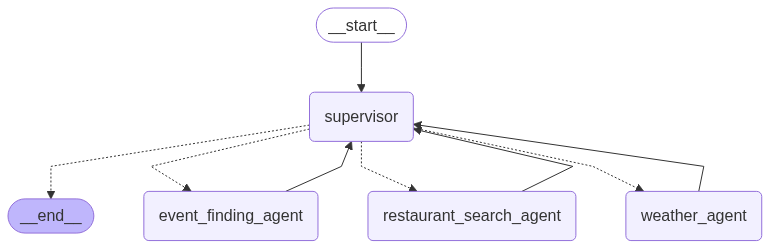

In [76]:
from IPython.display import display, Image
display(Image(supervisor.get_graph().draw_mermaid_png()))

## 💬 Testing Our Multi-Agent System - The First Contact

Time to put our complete system to the test! Let's see how the supervisor handles a user request and delegates it to the appropriate specialist agent.

> 💡 **Let's see what happens**: We'll intentionally send an ambiguous request to see how our system handles it. This will demonstrate how the supervisor asks for clarification before routing the task to a specialist.

In [23]:
for chunk in supervisor.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "Change my appointment",
            }
        ]
    },
):
    pretty_print_messages(chunk, last_message=True)


Update from node supervisor:


================================== Ai Message ==================================
Name: supervisor

Could you please clarify what type of appointment you’d like to change? For example, is it a maintenance appointment, a navigation-related meeting, or something that involves a repair manual? This will help me assign your request to the appropriate agent.




## 🗺️ Advanced Multi-Agent Architecture - Adding Task Descriptions

Now let's build an even more sophisticated multi-agent system! This version will allow the supervisor to include detailed task descriptions when handing off work to specialist agents.

```mermaid
flowchart TD
    A[User] -->|Query| B[Supervisor w/ Task Description]
    B -->|Task: Find French restaurants in Paris| C[Restaurant Agent]
    B -->|Task: Check weather in Madrid| D[Weather Agent]
    B -->|Task: Find jazz concerts in London| E[Events Agent]
    C -->|Response with restaurant info| B
    D -->|Response with weather forecast| B
    E -->|Response with event listings| B
    B -->|Final Answer| A
    
    style B fill:#77d5fa,stroke:#0984e3,color:black
    style C fill:#a8e6cf,stroke:#1b998b,color:black
    style D fill:#ffd3b6,stroke:#ff8b94,color:black
    style E fill:#d5b3ff,stroke:#9775fa,color:black
```

> 💡 **What's different?** In this enhanced version, the supervisor doesn't just route a request to an agent - it includes a detailed description of what the agent needs to do. This is like a manager giving specific instructions rather than just forwarding an email.

> 🤓 **Technical Note**: We're creating custom handoff tools that allow the supervisor to include a task description when delegating work. This gives the specialist agents more context about what they need to accomplish.

In [ ]:
# Import the necessary components for our advanced multi-agent system
from langgraph.types import Send
from typing import Annotated
from langchain_core.tools import tool, InjectedToolCallId
from langgraph.prebuilt import InjectedState
from langgraph.graph import StateGraph, START, MessagesState
from langgraph.types import Command

# This function creates a custom tool that allows the supervisor to pass task descriptions to agents
def create_task_description_handoff_tool(
    *, agent_name: str, description: str | None = None
):
    # Create a name for the tool based on the agent name
    name = f"transfer_to_{agent_name}"
    # Set a description for the tool if one wasn't provided
    description = description or f"Ask {agent_name} for help."

    # Define the actual handoff tool
    @tool(name, description=description)
    def handoff_tool(
        # The supervisor will provide this parameter - a description of what needs to be done
        task_description: Annotated[
            str,
            "Description of what the next agent should do, including all of the relevant context.",
        ],
        # This parameter is injected by the system - the supervisor doesn't need to provide it
        state: Annotated[MessagesState, InjectedState],
    ) -> Command:
        # Create a message containing the task description
        task_description_message = {"role": "user", "content": task_description}
        # Prepare the input for the agent, including the task description
        agent_input = {**state, "messages": [task_description_message]}
        # Return a command to go to the specified agent
        return Command(
            # This tells the system to go to the specified agent
            goto=[Send(agent_name, agent_input)],
            # This tells the system to return to the parent graph after the agent is done
            graph=Command.PARENT,
        )

    # Return the handoff tool
    return handoff_tool

# Create handoff tools for each of our specialist agents

# Tool for handing off to the restaurant agent with a task description
assign_to_restaurant_agent_with_description = create_task_description_handoff_tool(
    agent_name="restaurant_search_agent",
    description="Assign task to the restaurant recommendation agent.",
)

# Tool for handing off to the weather agent with a task description
assign_to_weather_agent_with_description = create_task_description_handoff_tool(
    agent_name="weather_agent",
    description="Assign task to the weather information agent.",
)

# Tool for handing off to the events agent with a task description
assign_to_event_agent_with_description = create_task_description_handoff_tool(
    agent_name="event_finding_agent",
    description="Assign task to the event discovery agent.",
)

# Create a supervisor agent that uses these handoff tools
supervisor_agent_with_description = create_react_agent(
    model="openai:gpt-4.1",
    tools=[
        assign_to_restaurant_agent_with_description,
        assign_to_weather_agent_with_description,
        assign_to_event_agent_with_description,
    ],
    prompt=(
        "You are a supervisor managing three agents:\n"
        "- a restaurant search agent. Assign restaurant recommendation tasks to this agent\n"
        "- a weather agent. Assign weather information queries to this agent\n"
        "- an event finding agent. Assign event discovery tasks to this agent\n"
        "Assign work to one agent at a time, do not call agents in parallel."
        "Do not do any work yourself."
        "Make sure to ask the user for any missing information needed to complete the task."
        "If you are not sure which agent to assign the task to, ask the user for more information."
        f"\nCurrent time: {datetime.now()}."
    ),
    name="supervisor",
)

# Now we create our state graph - this defines how messages flow between components
supervisor_with_description = (
    # Initialize a state graph with message state
    StateGraph(MessagesState)
    # Add our supervisor node with connections to all specialist agents
    .add_node(
        supervisor_agent_with_description, 
        destinations=("restaurant_search_agent", "weather_agent", "event_finding_agent")
    )
    # Add our specialist agent nodes
    .add_node(restaurant_search_agent)
    .add_node(weather_agent)
    .add_node(event_finding_agent)
    # Define the starting point - conversations begin with the supervisor
    .add_edge(START, "supervisor")
    # Define edges from each specialist back to the supervisor
    .add_edge("restaurant_search_agent", "supervisor")
    .add_edge("weather_agent", "supervisor")
    .add_edge("event_finding_agent", "supervisor")
    # Compile the graph to make it executable
    .compile()
)

## 🌟 Final Test - Our Complete Travel Assistant System

Now let's test our enhanced multi-agent system with task descriptions! We'll send the same ambiguous request as before to see how this version handles it.

> 💡 **What to expect**: The supervisor should recognize that "Change my appointment" is ambiguous and ask the user for clarification. Try running this cell and then responding with more specific information to see how the system routes your request to the appropriate specialist agent.

> 👏 **Congratulations!** You've now built a sophisticated multi-agent system that can help travelers with restaurants, weather, and events. This is just the beginning of what's possible with agent-based AI systems!

In [14]:
events = supervisor.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "Change my appointment",
            }
        ]
    },
)

# 🌟 Conclusion and Next Steps

Congratulations on completing this multi-agent systems workshop! Let's recap what we've built and learned:

## 🔧 What We Built

```mermaid
flowchart TD
    A[Multi-Agent Travel Assistant] --> B[Restaurant Agent]
    A --> C[Weather Agent]
    A --> D[Events Agent]
    B --> B1[Database Search]
    B --> B2[Web Search]
    B --> B3[Reservation Management]
    C --> C1[Weather API Integration]
    D --> D1[Events Web Search]
    
    style A fill:#77d5fa,stroke:#0984e3,color:black
    style B fill:#a8e6cf,stroke:#1b998b,color:black
    style C fill:#ffd3b6,stroke:#ff8b94,color:black
    style D fill:#d5b3ff,stroke:#9775fa,color:black
```

1. 🤖 **Three Specialist Agents**:
   - Restaurant recommendation agent with database and web search capabilities
   - Weather information agent integrated with the OpenWeatherMap API
   - Event discovery agent that can find activities in any city

2. 🧠 **Two Supervisor Architectures**:
   - Basic supervisor that routes requests to specialists
   - Advanced supervisor that includes detailed task descriptions

## 💡 Key Takeaways

- 🎯 **Specialization**: By creating focused agents with specific skills, each one can be optimized for its domain
- 🔗 **Coordination**: A supervisor can intelligently route tasks to the right specialist
- 🔌 **Tool Integration**: Agents gain capabilities by connecting to databases, APIs, and web searches
- 📗 **Context Management**: Properly managing context between agents ensures seamless user experience

## 🚀 Next Steps for the Curious

Want to expand this system? Here are some ideas:

1. 💼 Add a **Hotel Booking Agent** that can search for accommodations
2. 🚊 Create a **Transportation Agent** for finding flights, trains, and local transit
3. 🌐 Implement a **Translation Agent** to help with language barriers
4. 🗂️ Add **Memory** so the system remembers user preferences across conversations
5. 💠 Try **Parallel Execution** to have multiple agents working on different aspects simultaneously

💪 Happy agent building! 🚀

# 👊 Your Turn: Hands-On Practice Tasks

Now it's your turn to build some agents! Below are two tasks - complete them to solidify your understanding of multi-agent systems.

## 🙂 Task 1: Create a Budget Tracker Agent (Easy)

In this task, you'll create a simple agent that helps users track their travel expenses. The agent should:
1. Allow users to add expenses with categories (e.g., food, transportation, accommodation, etc.)
2. Show the total expenses and breakdown by category
3. Support basic budget management commands

```mermaid
flowchart LR
    A[User] --> B[Budget Tracker Agent]
    B --> C{Command Type}
    C -->|Add Expense| D[Add to Database]
    C -->|Show Summary| E[Calculate Totals]
    C -->|Budget Status| F[Compare to Budget]
    D --> G[Confirmation]
    E --> G[Summary Report]
    F --> G[Budget Status]
    G --> A
    
    style B fill:#ff9ff3,stroke:#f368e0,color:black
    style G fill:#badc58,stroke:#6ab04c,color:black
```

### 💻 What You Need to Implement:

1. Create the necessary SQLite database tools
2. Build the budget tracking agent
3. Test it with some sample queries

> 💡 **Hint**: You can use the restaurant reservation code as a reference for how to work with SQLite databases.

In [ ]:
# Task 1: Budget Tracker Agent

# TODO: Import necessary libraries
import sqlite3
from datetime import datetime
from langchain_core.tools import tool

# TODO: Create a database initialization function
def initialize_budget_db():
    """Initialize the budget tracking database if it doesn't exist."""
    conn = sqlite3.connect('./data/travel_budget.db')
    cursor = conn.cursor()
    
    # Create expenses table
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS expenses (
        id INTEGER PRIMARY KEY,
        amount REAL NOT NULL,
        category TEXT NOT NULL,
        description TEXT,
        date TEXT NOT NULL
    )
    ''')
    
    # Create budget table
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS budget (
        id INTEGER PRIMARY KEY,
        total_amount REAL NOT NULL,
        start_date TEXT NOT NULL,
        end_date TEXT NOT NULL,
        description TEXT
    )
    ''')
    
    conn.commit()
    conn.close()
    print("Budget database initialized successfully!")
    
# Initialize the database
initialize_budget_db()

# TODO: Implement these tool functions

@tool
def add_expense(amount: float, category: str, description: str = None):
    """Add a new expense to the budget tracker.
    
    Args:
        amount: The amount spent (as a number).
        category: The category of the expense (e.g., 'food', 'transport', 'accommodation').
        description: Optional description of the expense.
        
    Returns:
        str: Confirmation message with the expense ID.
    """
    # TODO: Implement the function to add an expense to the database
    # Hint: Use the current date for the expense date
    pass  # Replace with your implementation

@tool
def get_expense_summary():
    """Get a summary of all expenses by category.
    
    Returns:
        dict: A dictionary with total expenses and breakdown by category.
    """
    # TODO: Implement the function to get a summary of expenses
    pass  # Replace with your implementation

@tool
def set_budget(total_amount: float, start_date: str, end_date: str, description: str = None):
    """Set a new budget for a specific time period.
    
    Args:
        total_amount: The total budget amount.
        start_date: Budget start date in 'YYYY-MM-DD' format.
        end_date: Budget end date in 'YYYY-MM-DD' format.
        description: Optional description for the budget.
        
    Returns:
        str: Confirmation message.
    """
    # TODO: Implement the function to set a budget
    pass  # Replace with your implementation

@tool
def get_budget_status():
    """Get the current budget status.
    
    Returns:
        dict: Budget information with total, spent, and remaining amounts.
    """
    # TODO: Implement the function to check budget status
    pass  # Replace with your implementation

# TODO: Create the Budget Tracker Agent

# budget_tracker_agent = create_react_agent(
#     model="openai:gpt-4.1",
#     tools=[add_expense, get_expense_summary, set_budget, get_budget_status],
#     prompt=(
#         # TODO: Write a suitable prompt for the budget tracker agent
#     ),
#     name="budget_tracker_agent",
# )

# For testing your agent:
# for chunk in budget_tracker_agent.stream(
#     {"messages": [{"role": "user", "content": "I spent $45 on dinner last night"}]},
# ):
#     pretty_print_messages(chunk)

## 💪 Task 2: Create a Collaborative Planning Agent (Challenging)

For this more challenging task, you'll create a trip planning agent that collaborates with our existing agents to create a comprehensive travel plan. The planning agent should:

1. Work with the restaurant, weather, and events agents to create a coherent day plan
2. Incorporate all the information into a single, well-structured itinerary
3. Handle follow-up questions about the plan

```mermaid
flowchart TD
    A[User] -->|"Plan my day in Paris"| B[Planning Agent]
    B -->|"Weather in Paris?"| C[Weather Agent] 
    B -->|"Restaurants in Paris?"| D[Restaurant Agent]
    B -->|"Events in Paris today?"| E[Events Agent]
    C --> |"Weather forecast"| B
    D --> |"Restaurant options"| B
    E --> |"Event options"| B
    B --> |"Complete itinerary"| A
    
    style B fill:#a29bfe,stroke:#6c5ce7,color:black
    style C fill:#ffd3b6,stroke:#ff8b94,color:black
    style D fill:#a8e6cf,stroke:#1b998b,color:black
    style E fill:#d5b3ff,stroke:#9775fa,color:black
```

### 💻 What You Need to Implement:

1. Create a planning agent that can coordinate with our three existing agents
2. Implement a way for this agent to interact with the specialist agents
3. Create a format for presenting the complete itinerary

> 💡 **Challenge**: This requires understanding how agents can communicate with each other! You'll need to think about how to share context between agents and how to assemble the final plan from multiple sources.

> 👀 **Bonus**: Add the budget tracking agent from Task 1 to also handle budget considerations in the planning!

In [ ]:
# Task 2: Collaborative Planning Agent

# TODO: Import necessary libraries
from langchain_core.tools import tool
from typing import Dict, List, Any
from langgraph.prebuilt import create_react_agent
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command, Send

# TODO: Create agent interaction tools

@tool
def query_weather_for_planning(city: str) -> str:
    """Get weather information for planning purposes.
    
    Args:
        city: The city to check weather for.
        
    Returns:
        str: Weather information for the specified city.
    """
    # TODO: Implement a way to query the weather agent and get results
    # Hint: You can use the weather_agent we created earlier
    pass  # Replace with your implementation

@tool
def find_restaurants_for_planning(city: str, cuisine: str = None, meal_time: str = None) -> str:
    """Find restaurant recommendations for a specific meal in the itinerary.
    
    Args:
        city: The city to find restaurants in.
        cuisine: Optional cuisine preference.
        meal_time: Which meal (breakfast, lunch, dinner).
        
    Returns:
        str: Restaurant recommendations.
    """
    # TODO: Implement a way to query the restaurant agent and get results
    # Hint: You can use the restaurant_search_agent we created earlier
    pass  # Replace with your implementation

@tool
def find_events_for_planning(city: str, interest: str = None, time_of_day: str = None) -> str:
    """Find events recommendations for the itinerary.
    
    Args:
        city: The city to find events in.
        interest: Optional specific interest area.
        time_of_day: When the event should take place (morning, afternoon, evening).
        
    Returns:
        str: Event recommendations.
    """
    # TODO: Implement a way to query the events agent and get results
    # Hint: You can use the event_finding_agent we created earlier
    pass  # Replace with your implementation

@tool
def create_formatted_itinerary(city: str, date: str, weather: str, meals: Dict, activities: List) -> str:
    """Create a formatted travel itinerary from all collected information.
    
    Args:
        city: The destination city.
        date: The date of the itinerary.
        weather: Weather information.
        meals: Dictionary with meal plans.
        activities: List of activities.
        
    Returns:
        str: A nicely formatted travel itinerary in markdown.
    """
    # TODO: Implement a function that formats all the information into a cohesive itinerary
    pass  # Replace with your implementation

# TODO: Create the Planning Agent

# planning_agent = create_react_agent(
#     model="openai:gpt-4.1",
#     tools=[
#         query_weather_for_planning, 
#         find_restaurants_for_planning, 
#         find_events_for_planning,
#         create_formatted_itinerary
#     ],
#     prompt=(
#         # TODO: Write a suitable prompt for the planning agent
#         # It should understand how to create a full day plan including meals, 
#         # activities, and considering the weather
#     ),
#     name="planning_agent",
# )

# TODO: Advanced - Create a multi-agent graph that connects the planning agent with specialist agents

# For testing your agent:
# for chunk in planning_agent.stream(
#     {"messages": [{"role": "user", "content": "Plan a day in Paris for tomorrow. I love French food and art."}]},
# ):
#     pretty_print_messages(chunk)

# 🌟 Workshop Completion

## 🎒 Task Solutions

After you complete your tasks, compare with fellow participants to see different approaches. There's often more than one way to architect a multi-agent system!

If you're stuck, don't hesitate to ask for help - building these systems involves many moving parts and sometimes a fresh perspective helps.

## 📝 Key Learning Points

- Multi-agent systems allow for task specialization and division of labor
- The supervisor pattern lets us route tasks intelligently
- Tools give agents capabilities beyond simple text generation
- Breaking down complex tasks into subtasks makes problems more manageable
- Agent coordination requires thoughtful design of communication patterns

## 💎 Resources for Further Learning

- LangGraph Documentation: [https://github.com/langchain-ai/langgraph](https://github.com/langchain-ai/langgraph)
- Multi-Agent Paper: ["The Rise and Potential of Large Language Model Based Agents: A Survey"](https://arxiv.org/abs/2309.07864)
- Emerging Patterns: [Multi-Agent Collaboration Techniques](https://lilianweng.github.io/posts/2023-06-23-agent/)

## 🎉 Thank You!

Thank you for participating in this workshop! We hope you enjoyed exploring multi-agent systems and are inspired to build your own AI collaborations.

> 💡 **Remember**: The most powerful AI systems aren't solo performers - they're orchestras of specialized agents working in harmony!

**- The Multi-Agent Systems Workshop Team**